## Read in the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from fancyimpute import KNN
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf

D:\Games\Anaconda\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
D:\Games\Anaconda\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
D:\Games\Anaconda\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)
D:\Games\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the data, which is spread accross multiple files
real_estate1 = pd.read_excel('./data/immo_by_municipality_1980-1989.xlsx',
                             dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate2 = pd.read_excel('./data/immo_by_municipality_1990-1999.xlsx',
                             dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate3 = pd.read_excel('./data/immo_by_municipality_2000-2009.xlsx',
                             dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})
real_estate4 = pd.read_excel('./data/immo_by_municipality_2010-2019.xlsx',
                             dtype = {'CD_YEAR': np.int16, 'CD_REFNIS': str})

# Concatenate the data frames
real_estate = pd.concat([real_estate1, real_estate2, real_estate3, real_estate4], axis = 0,
                        copy = False)
del real_estate1, real_estate2, real_estate3, real_estate4

## Exploratory Data Analysis

In [3]:
real_estate.shape

(509295, 17)

In [4]:
real_estate.head()

,CD_YEAR,CD_TYPE_NL,CD_TYPE_FR,CD_REFNIS,CD_REFNIS_NL,CD_REFNIS_FR,CD_PERIOD,CD_CLASS_SURFACE,MS_TOTAL_TRANSACTIONS,MS_TOTAL_PRICE,MS_TOTAL_SURFACE,MS_MEAN_PRICE,MS_P10,MS_P25,MS_P50,MS_P75,MS_P90
0,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q1,totaal / total,15,938053.0,4671.0,62536.866667,31945.0,54537.0,62519.0,72936.0,91721.0
1,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q2,totaal / total,18,1051097.0,4953.0,58394.277778,32226.0,54537.0,60734.0,61973.0,76847.0
2,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q3,totaal / total,11,569785.0,4116.0,51798.636364,39043.0,42142.0,54537.0,63461.0,64452.0
3,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,Q4,totaal / total,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980,gewone woonhuizen,maisons d'habitation,11001,AARTSELAAR,AARTSELAAR,S1,totaal / total,33,1989150.0,9624.0,60277.272727,32226.0,54537.0,60734.0,69559.0,76847.0


In [5]:
real_estate.CD_PERIOD.unique()

array(['Q1', 'Q2', 'Q3', 'Q4', 'S1', 'S2', 'Y'], dtype=object)

First, we can see that we have quarterly, biannual and yearly statistics. We will only consider the yearly ones in this project<br>
Second, we have some percentile and quantile information, that we do not need, so we can filter out those columns<br>
Third, the column names are not very meaningful, rename them

In [6]:
real_estate = real_estate[real_estate.CD_PERIOD == 'Y']

real_estate = real_estate[['CD_YEAR', 'CD_TYPE_FR', 'CD_REFNIS', 'CD_REFNIS_FR',
                           'MS_TOTAL_TRANSACTIONS', 'MS_TOTAL_PRICE', 'MS_TOTAL_SURFACE',
                           'MS_MEAN_PRICE']]

real_estate.rename(columns = {'CD_YEAR': 'Year', 'CD_TYPE_FR': 'Property_Type', 'CD_REFNIS': 'REFNIS',
                              'CD_REFNIS_FR': 'Municipality_Name',
                              'MS_TOTAL_TRANSACTIONS': 'Total_Transactions',
                              'MS_TOTAL_PRICE': 'Total_Price',
                              'MS_TOTAL_SURFACE': 'Total_Area', 'MS_MEAN_PRICE': 'Mean_Price'},
                   inplace = True)

Find the number of unique values for each column, to understand what we have to deal with

In [7]:
real_estate.nunique()

Year                     38
Property_Type             4
REFNIS                  589
Municipality_Name       588
Total_Transactions     1112
Total_Price           58673
Total_Area            41125
Mean_Price            59102
dtype: int64

We have 38 years, from 1980 till 2017, so the Year count is as expected<br>
There are 4 property types, namely:

In [8]:
real_estate.Property_Type.unique()

array(["maisons d'habitation", 'villas, bungalows, maisons de campagne',
       'appartements, flats, studios', 'terrains à bâtir'], dtype=object)

In [9]:
real_estate.groupby('Property_Type').agg('count').reset_index()

,Property_Type,Year,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
0,"appartements, flats, studios",16348,16348,16348,16348,9239,0,9239
1,maisons d'habitation,22354,22354,22354,22354,22101,22101,22101
2,terrains à bâtir,20507,20507,20507,20507,18435,18435,18435
3,"villas, bungalows, maisons de campagne",19698,19698,19698,19698,9426,9426,9426


In [10]:
real_estate.groupby('Property_Type').agg('sum').reset_index()

,Property_Type,Year,Total_Transactions,Total_Price,Total_Area,Mean_Price
0,"appartements, flats, studios",32705865.0,1106400,1.415378e+11,0.000000e+00,1.163915e+09
1,maisons d'habitation,44674437.0,2505623,2.497702e+11,1.603081e+09,2.241651e+09
2,terrains à bâtir,40952556.0,971912,4.648803e+10,1.154819e+09,9.911973e+05
3,"villas, bungalows, maisons de campagne",39389378.0,361986,9.549157e+10,5.550089e+08,2.462367e+09


There are comparable number of transactions for all 4 property types, with 2.5 million house transactions, about a million each apartment and plot transactions and 300 k villa transactions. These seem reasonable differences<br>
However, we have 589 unique REFNIS values (which is to be expected, since there are 589 Belgian municipalities), but only 588 municipality names. Let us find out why

In [11]:
temp = real_estate.drop_duplicates(subset = ['REFNIS', 'Municipality_Name']).groupby('Municipality_Name').size()
temp[temp == 2]

Municipality_Name
SAINT-NICOLAS    2
dtype: int64

In [12]:
real_estate.loc[real_estate.Municipality_Name == 'SAINT-NICOLAS', 'REFNIS'].unique()

array(['46021', '62093'], dtype=object)

A simple search on Google for 'Belgian municipality SAINT-NICOLAS' shows that there are 2 Belgian municipalities with this name, one in the Province of East Flanders and another one in the Province of Liège. Mystery solved<br><br>
Let us check if the amount of data varies over time. This is in theory something we do not expect. While there are definitely more transactions in the recent years, due to population growth, the data consist of consolidated information, whose volume should be constant

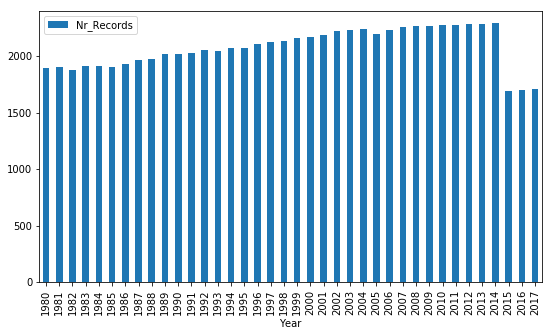

In [13]:
temp = real_estate.groupby('Year').size().reset_index(name = 'Nr_Records')
temp.plot.bar(x = 'Year', y = 'Nr_Records', figsize = (9, 5));

There seems to be an increasing amount of data as time goes by, however, as of 2015, there is a sharp drop

In [14]:
real_estate.loc[real_estate.Year >= 2015, 'Property_Type'].unique()

array(["maisons d'habitation", 'villas, bungalows, maisons de campagne',
       'appartements, flats, studios'], dtype=object)

It seems that statistics about plots are no longer gathered or communicated as of 2015. We could drop this property type for all years, but instead let us only keep the data for 2014 and earlier, when all 4 property types are available

In [15]:
real_estate = real_estate[real_estate.Year <= 2014]

We still need to investigate the reason for having more data as time goes by. If we had data for all years, all property types and all municipalities, we would have

In [16]:
35 * 4 * 589

82460

records, however we only have

In [17]:
real_estate.shape[0]

73801

In [18]:
print(real_estate.Total_Transactions.min(), real_estate.Total_Transactions.max())

1 5699


It looks like 0's are not reported and we are bound to have years when there are no transactions for some property types for the smaller municipalities<br>
We will need to add these 0's because the machine learning algorithm has to be aware of them<br>
Before doing that, let us check for correlation between year and price/area

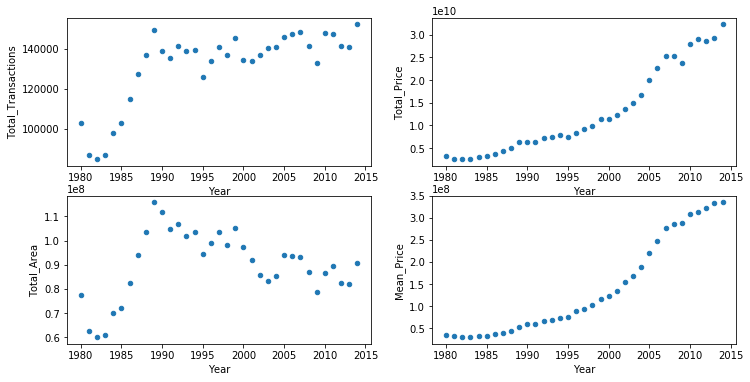

In [19]:
temp = real_estate.groupby('Year').agg('sum').reset_index()
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))

for ycol, ax in zip(['Total_Transactions', 'Total_Price', 'Total_Area', 'Mean_Price'],
                    axes.reshape(4, )):
    temp.plot.scatter(x = 'Year', y = ycol, ax = ax)

The number of transactions went down first, then sharply up for a few years and then it fluctuated with only a slight upward tendency<br>
The total area went followed the same pattern initially (i.e. first down and then sharply up), however, there is a clear downward tendency since 1990<br>
The price (both total and mean) went slightly down first and then steadily up, except for a period of a few years around 2005 when it went sharply up<br>
The computed correlations reflect these findings

In [20]:
temp.corr().iloc[0]

Year                  1.000000
Total_Transactions    0.752870
Total_Price           0.952937
Total_Area            0.181720
Mean_Price            0.948791
Name: Year, dtype: float64

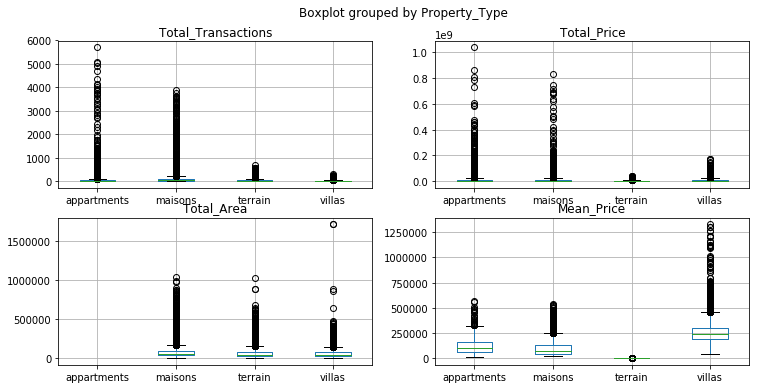

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))

for xcol, ax in zip(['Total_Transactions', 'Total_Price', 'Total_Area', 'Mean_Price'],
                    axes.reshape(4, )):
    real_estate.boxplot(column = xcol, by = 'Property_Type', ax = ax)
    ax.set_xticklabels(['appartments', 'maisons', 'terrain', 'villas'])
    ax.set_xlabel(None)

The number of transactions and total price have way more spread for apartments and houses than for plots and villas, which makes sense, since the high values must come from municipalities which are part of big cities, where there are a lot more apartments and houses than plots and villas<br>
The total area has more or less the same spread across all property types (except for apartments, for which it is not given). However, since there are fewer transactions for plots than there are for houses and even fewer for villas, this means that the average area of villas is higher than that of plots which is higher than that of houses, a perfectly reasonable finding<br>
The average price has the most spread for villas, which is normal, since there are some municipalities with very expensive properties, like those at the North Sea and some Brussels municipalities. For plots, there seems to be very little spread, we will investigate why in the following section

## Missing Data and Data Consistency

In [22]:
real_estate.isnull().sum()

Year                      0
Property_Type             0
REFNIS                    0
Municipality_Name         0
Total_Transactions        0
Total_Price           18705
Total_Area            26932
Mean_Price            18705
dtype: int64

We've got quite a few records with missing price and even more with missing area

In [23]:
real_estate[real_estate.Total_Price.isnull()].head()

,Year,Property_Type,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
1075,1980,maisons d'habitation,24137,GLABBEEK,7,NaN,NaN,NaN
1382,1980,maisons d'habitation,33016,MESSINES,6,NaN,NaN,NaN
2095,1980,maisons d'habitation,45062,HOREBEKE,6,NaN,NaN,NaN
2940,1980,maisons d'habitation,63001,AMBLEVE,7,NaN,NaN,NaN
3056,1980,maisons d'habitation,63067,SAINT-VITH,8,NaN,NaN,NaN


It seems that price and area are not reported when the number of transactions is small

In [24]:
print(real_estate[real_estate.Total_Price.isnull()].Total_Transactions.unique())
print(real_estate[real_estate.Total_Price.isnull()].shape[0])

[7 6 8 9 5 1 2 3 4]
18705


The limit is 10. When there are fewer than 10 transactions, there is no price or area. We will need to impute these values somehow (done in the Data Imputation section)<br>
We already saw in the previous section that the area is never provided for apartments, let us make sure that it is always provided for the other property types, when the price exists

In [25]:
len(real_estate[(real_estate.Property_Type != 'appartements, flats, studios')
                & (real_estate.Total_Price.notnull()) & (real_estate.Total_Area.isnull())])

0

Ok, so the appartments never have an area, while the other property types always have an area, provided there are 10 or more transactions. It probably makes sense to add a feature which specifies this<br>
Let us check now if the mean price is always as expected

In [26]:
real_estate[(real_estate.Mean_Price.notnull())
            & (np.round(real_estate.Mean_Price) != np.round(real_estate.Total_Price / \
                                                    real_estate.Total_Transactions))].head()

,Year,Property_Type,REFNIS,Municipality_Name,Total_Transactions,Total_Price,Total_Area,Mean_Price
7868,1980,terrains à bâtir,11001,AARTSELAAR,91,2034217.0,67912.0,29.953719
7875,1980,terrains à bâtir,11002,ANVERS,339,13125867.0,247050.0,53.130407
7882,1980,terrains à bâtir,11004,BOECHOUT,51,1385191.0,58141.0,23.824685
7896,1980,terrains à bâtir,11007,BORSBEEK,42,926291.0,24985.0,37.073884
7903,1980,terrains à bâtir,11008,BRASSCHAAT,112,3918831.0,149572.0,26.200298


In [27]:
real_estate[(real_estate.Mean_Price.notnull())
            & (np.round(real_estate.Mean_Price) != np.round(real_estate.Total_Price / \
                                        real_estate.Total_Transactions))].Property_Type.value_counts()

terrains à bâtir    18435
Name: Property_Type, dtype: int64

In [28]:
2034217.0 / 67912.0

29.95371951937802

The mean price for plots is the mean price per square metre, while for the other property types, it is the mean price per property. We will unify the meaning of the columns

In [29]:
real_estate['Mean_Price'] = real_estate.Total_Price / real_estate.Total_Transactions
real_estate['Mean_Area'] = real_estate.Total_Area / real_estate.Total_Transactions

We need now to create the missing records, those for which the number of transactions is 0 and which are not present in the data

In [30]:
# We store the municiality names. Even though they are not really needed for machine learning,
# they make the data much more user-friendly
mun_data = real_estate[['REFNIS', 'Municipality_Name']].drop_duplicates()    

In [31]:
# Generate all possible values for year, property type and municipality
all_years = real_estate.Year.unique()
all_prop_types = real_estate.Property_Type.unique()
all_muns = real_estate.REFNIS.unique()

In [32]:
# Create the cartesian product
grid = np.array(list(product(*[all_years, all_prop_types, all_muns])))
# Create the full data frame
grid = pd.DataFrame(np.vstack(grid), columns = ['Year', 'Property_Type', 'REFNIS'])
grid.Year = grid.Year.astype(np.int64)
# Merge the data with the full frame
real_estate = grid.merge(real_estate, on = ['Year', 'Property_Type', 'REFNIS'], how = 'left')

In [33]:
# Add the municipality names as a new column
real_estate = real_estate.merge(mun_data, on = 'REFNIS', suffixes = ('', '_y'), copy = False)

In [34]:
# Update the municipality names
real_estate['Municipality_Name'] = real_estate['Municipality_Name_y']
real_estate.drop('Municipality_Name_y', axis = 1, inplace = True)
# Fill the newly added rows with 0's. We cannot mass replace with 0, as there are existing NA's
# that we need to handle
real_estate.loc[real_estate.Total_Transactions.isnull(), 'Total_Transactions'] = 0
real_estate.Total_Transactions = real_estate.Total_Transactions.astype(np.int64)
real_estate.loc[real_estate.Total_Transactions == 0, 'Total_Price'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Total_Area'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Mean_Price'] = 0
real_estate.loc[real_estate.Total_Transactions == 0, 'Mean_Area'] = 0

## Basic Feature Engineering

In [35]:
# Create a feature to distinguish imputed prices
real_estate['Is_Price_Imputed'] = 0
real_estate.loc[real_estate.Total_Price.isnull(), 'Is_Price_Imputed'] = 1

In [36]:
# The area is always missing for apartments, create a feature for this
real_estate['Is_Area_Missing'] = 0
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Is_Area_Missing'] = 1
# Set the total and mean areas to 0 for apartments, in order to eliminate the NA's
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Total_Area'] = 0
real_estate.loc[real_estate.Property_Type == 'appartements, flats, studios', 'Mean_Area'] = 0

In [37]:
# Create a feature to distinguish the imputed areas
real_estate['Is_Area_Imputed'] = 0
real_estate.loc[real_estate.Total_Price.isnull() &
                (real_estate.Property_Type != 'appartements, flats, studios'), 'Is_Area_Imputed'] = 1

## Data Imputation

We need to impute the price and area for the records with fewer than 10 transactions. While we could do it based on the current data, there is not much information for the imputation algorithm. It could work based on year/municipality, but it is likely to yield poor results, since it would be unable to find similar municipalities within the same year<br>
We will add the district, province and region for each municipality, since municipalities under the same district, province or region are likely to have similar real estate prices<br>
We will also add population and tax information, since municipalities with similar populations and/or similar income are likely to have similar real estate prices<br>
Let us add population information first

In [38]:
# Create a base data frame with the municipality IDs
pop_data = pd.DataFrame(data = real_estate.REFNIS.unique(), columns = ['REFNIS'])

In [39]:
# Read the population data as a dictionary of data frames
pop_data_temp = pd.read_excel('./data/Population_de_droit_au_1_janvier,_par_commune,_par_sexe_2011_2017.xls', sheet_name = None, skiprows = 1, usecols = 'A, E', dtype = {' code INS': str})

In [40]:
pop_data_temp.keys()

odict_keys(['Population de droit en 2018', 'Population de droit en 2017', 'Population de droit en 2016', 'population de droit en 2015', 'Population de droit en 2014', 'Population de droit en 2013', 'Population de droit en 2012', 'Population de droit en 2011'])

In [41]:
# Convert the data from separate data frames into a single one
for key, value in pop_data_temp.items():
    value.rename(columns = {' code INS': 'REFNIS', 'Total': key[-4:]}, inplace = True)
    pop_data = pop_data.merge(value, on = 'REFNIS', copy = False)

In [42]:
pop_data.head()

,REFNIS,2018,2017,2016,2015,2014,2013,2012,2011
0,11001,14304.0,14222.0,14262.0,14157.0,14207.0,14226.0,14281.0,14311.0
1,11002,523248.0,520504.0,517042.0,513570.0,510610.0,507911.0,502604.0,493517.0
2,11004,13120.0,12908.0,12844.0,12792.0,12804.0,12774.0,12724.0,12728.0
3,11005,17970.0,17788.0,17737.0,17559.0,17231.0,17227.0,17166.0,16989.0
4,11007,10685.0,10581.0,10540.0,10465.0,10451.0,10278.0,10233.0,10207.0


In [43]:
# Transform the data from horizontal to vertical
pop_data = pd.melt(pop_data, id_vars = 'REFNIS', value_vars = ['2018', '2017', '2016', '2015', '2014',
                '2013', '2012', '2011'], var_name = 'Year', value_name = 'Population')
pop_data.Population = pop_data.Population.astype(np.int64)
pop_data.Year = pop_data.Year.astype(np.int64)

In [44]:
pop_data.head()

,REFNIS,Year,Population
0,11001,2018,14304
1,11002,2018,523248
2,11004,2018,13120
3,11005,2018,17970
4,11007,2018,10685


We only have data from 2011 onwards. We need to estimate the values for the previous years. While it is most likely not the best method and the assumptions do not hold, we will use linear regression for simplicity's sake

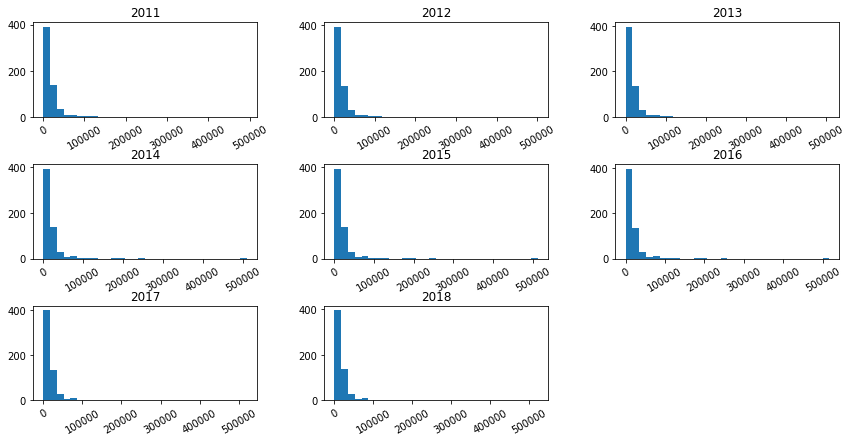

In [45]:
pop_data.hist(column = 'Population', by = 'Year', bins = 30, figsize = (14, 7), xrot = 30);

The data is highly right skewed. We will log transform it to reduce skewness, even though the assumptions of linearity will still not hold

In [46]:
# Create a copy of the initial data, as we will need to dummify it
# Order it first, as this will be needed when getting the predictions
pop_data.sort_values(by = ['Year', 'REFNIS'], ascending = [False, True], inplace = True)
populations = pop_data.copy()

In [47]:
pop_data.Population = np.log(pop_data.Population)

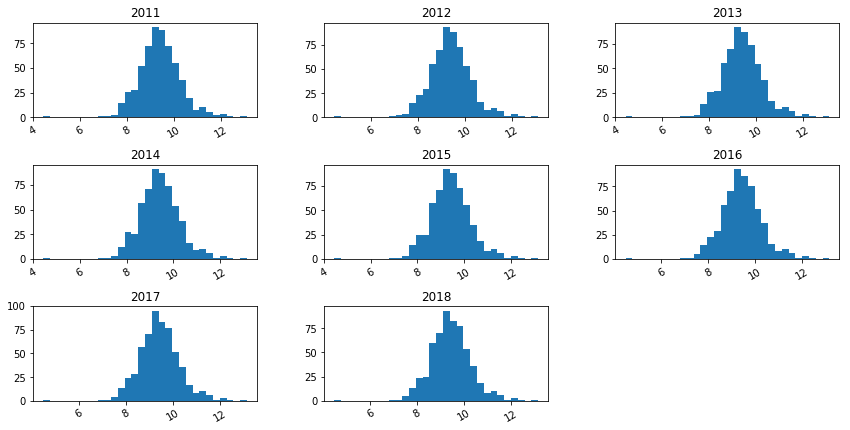

In [48]:
pop_data.hist(column = 'Population', by = 'Year', bins = 30, figsize = (14, 7), xrot = 30);

In [49]:
pop_data = pd.get_dummies(pop_data, columns = ['REFNIS'], prefix = ['Mun'])

We will create a regressor for all municipalities in a go instead of for each one individualy, as we only have data for 8 years and there are municipalities whose population goes up and down during this time, which might create a regressor with negative slope

In [50]:
linreg = linear_model.LinearRegression(normalize = True)
X = pop_data[pop_data.columns[pop_data.columns != 'Population']]
y = pop_data.Population
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In order to make predictions for the years 1980 until 2010, we make a copy of the data for the year 2011, subtract 1, predict and repeat

In [51]:
temp_pop = pop_data.loc[pop_data.Year == 2011,
                        [col for col in pop_data.columns if col != 'Population']].copy()
for i in range(2010 - 1980 + 1):
    temp_pop.Year = temp_pop.Year - 1
    preds = linreg.predict(temp_pop)
    temp_pop1 = pd.DataFrame({'Year': (2010 - i),
                              'REFNIS': populations.loc[populations.Year == 2018,'REFNIS'],
                              'Population': np.round(np.exp(preds))})
    populations = pd.concat([populations, temp_pop1], axis = 0, copy = False, sort = False)
populations.Population = populations.Population.astype(np.int64)

In [52]:
real_estate = real_estate.merge(populations, on = ['Year', 'REFNIS'], copy = False)

Let us add tax information now

In [53]:
tax_struct = pd.read_excel('./data/TF_PSNL_INC_TAX_MUNTY.xlsx',
                           names = ['Year', 'REFNIS', 'Total_Income', 'Number_of_Incomes',
                                    'Number_Of_Residents', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS'],
                           usecols = 'A, B, F, G, AE, AH, AK, AN',
                           dtype = {'Year': np.int, 'Number_of_Incomes': np.int,
                                    'Number_Of_Residents': np.int, 'REFNIS': str, 'DSTR_REFNIS': str,
                                    'PROV_REFNIS': str, 'RGN_REFNIS': str})

In [54]:
# Brussels municipalities dot not have a province, so create an artificial one
#tax_struct.loc[tax_struct.PROV_REFNIS == 'nan', 'PROV_REFNIS'] = '100000'
tax_struct.loc[tax_struct.PROV_REFNIS.isnull(), 'PROV_REFNIS'] = '100000'

In [55]:
# Create 2 extra columns, the income per taxpayer and the income per resident
tax_struct['Income_Per_Taxpayer'] = tax_struct.Total_Income / tax_struct.Number_of_Incomes
tax_struct['Income_Per_Resident'] = tax_struct.Total_Income / tax_struct.Number_Of_Residents

In [56]:
# Do not use the number or residents to predict, as that is not available for all years
# We do not need to predict it, as it is the population we already predicted
tax_struct.drop(labels = 'Number_Of_Residents', axis = 1, inplace = True)

As for the population data, we do not have the tax information for all years (only from 2005 until 2015), so we need to estimate it. We wil also use linear regression. The steps are very similar to the population data regression

In [57]:
# Create a copy of the initial data, as we will need to dummify it
# Order it first, as this will be needed when getting the predictions
tax_struct.sort_values(by = ['Year', 'REFNIS'], ascending = [False, True], inplace = True)
tax_preds = tax_struct.copy()

In [58]:
# Log transform the data
tax_struct.Total_Income = np.log(tax_struct.Total_Income)
tax_struct.Number_of_Incomes = np.log(tax_struct.Number_of_Incomes)
tax_struct.Income_Per_Taxpayer = np.log(tax_struct.Income_Per_Taxpayer)
tax_struct.Income_Per_Resident = np.log(tax_struct.Income_Per_Resident)

In [59]:
tax_struct = pd.get_dummies(tax_struct, columns = ['REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS',
                                                   'RGN_REFNIS'],
                            prefix = ['Mun', 'Dstr', 'Prov', 'Reg'])

In [60]:
linreg = linear_model.LinearRegression(normalize = True)
X = tax_struct[tax_struct.columns[~tax_struct.columns.isin(['Total_Income', 'Number_of_Incomes',
                                                    'Income_Per_Taxpayer', 'Income_Per_Resident'])]]
y = tax_struct[tax_struct.columns[tax_struct.columns.isin(['Total_Income', 'Number_of_Incomes',
                                                    'Income_Per_Taxpayer', 'Income_Per_Resident'])]]
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In order to make predictions for the years 1980 until 2004, we make a copy of the data for the year 2005, subtract 1, predict and repeat

In [61]:
temp_tax = tax_struct.loc[tax_struct.Year == 2005, X.columns].copy()

In [62]:
for i in range(2005 - 1980 + 1):
    temp_tax.Year = temp_tax.Year - 1
    preds = linreg.predict(temp_tax)
    temp_tax1 = pd.DataFrame({'Year': (2004 - i),
                              'REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'REFNIS'],
                              'DSTR_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'DSTR_REFNIS'],
                              'PROV_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'PROV_REFNIS'],
                              'RGN_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'RGN_REFNIS'],
                              'Total_Income': np.exp(preds[:,0]),
                              'Number_of_Incomes': np.exp(preds[:,1]),
                              'Income_Per_Taxpayer': np.exp(preds[:,2]),
                              'Income_Per_Resident': np.exp(preds[:,3])})
    tax_preds = pd.concat([tax_preds, temp_tax1], axis = 0, copy = False, sort = False)

In order to make predictions for the years 2016 and 2017, we make a copy of the data for the year 2015, add 1, predict and repeat

In [63]:
temp_tax = tax_struct.loc[tax_struct.Year == 2015, X.columns].copy()

In [64]:
for i in range(2017 - 2016 + 1):
    temp_tax.Year = temp_tax.Year + 1
    preds = linreg.predict(temp_tax)
    temp_tax1 = pd.DataFrame({'Year': (2016 + i),
                              'REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'REFNIS'],
                              'DSTR_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'DSTR_REFNIS'],
                              'PROV_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'PROV_REFNIS'],
                              'RGN_REFNIS': tax_preds.loc[tax_preds.Year == 2015, 'RGN_REFNIS'],
                              'Total_Income': np.exp(preds[:,0]),
                              'Number_of_Incomes': np.round(np.exp(preds[:,1])),
                              'Income_Per_Taxpayer': np.exp(preds[:,2]),
                              'Income_Per_Resident': np.exp(preds[:,3])})
    tax_preds = pd.concat([tax_preds, temp_tax1], axis = 0, copy = False, sort = False)
tax_preds.Number_of_Incomes = tax_preds.Number_of_Incomes.astype(np.int64)

In [65]:
# Merge the tax information in the original data frame
real_estate = real_estate.merge(tax_preds, on = ['Year', 'REFNIS'], copy = False)

In [66]:
# Reorder the columns
cols = list(real_estate.columns)
real_estate = real_estate[cols[:2] + [cols[3]] + [cols[2]] + cols[15:18] + cols[4:15] + cols[18:]]

In [67]:
real_estate.columns

Index(['Year', 'Property_Type', 'Municipality_Name', 'REFNIS', 'DSTR_REFNIS',
       'PROV_REFNIS', 'RGN_REFNIS', 'Total_Transactions', 'Total_Price',
       'Total_Area', 'Mean_Price', 'Mean_Area', 'Is_Price_Imputed',
       'Is_Area_Missing', 'Is_Area_Imputed', 'Population', 'Total_Income',
       'Number_of_Incomes', 'Income_Per_Taxpayer', 'Income_Per_Resident'],
      dtype='object')

Ok, so now that we have quite a bit of information for each municipality, we can impute the missing price and area for the records with fewer than 10 transactions. We will do it per property type, first because it does not make sense to do it for heterogeneous data, and second because we cannot easily and meaningfully define a distance between property types. We will use KNN for defining the distance between records. Also, we will not include the records with no transactions in the imputation algorithm

In [68]:
# Order the data first, in order to have the records with the same property type grouped together
real_estate.sort_values(by = ['Property_Type', 'REFNIS', 'Year'], inplace = True)

In [69]:
# Create a copy of the initial data, as we will need to dummify it
temp_real_estate = real_estate[real_estate.Total_Transactions > 0].copy()

In [70]:
temp_real_estate = pd.get_dummies(temp_real_estate, columns = ['REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS',
                                                               'RGN_REFNIS'],
                                  prefix = ['Mun', 'Dstr', 'Prov', 'Reg'])

In [71]:
# Create an empty array for holding the imputed price and area
# We only impute the mean values and compute the total values based on the number of transactions
imputed_values = np.empty((temp_real_estate.shape[0], 2))
last_index = 0
# We min max scale the columns, in order for all of them to have the same weight
# We do not scale the dummified columns, neither the ones which are not used in the prediction
cols_to_scale = ['Year', 'Income_Per_Taxpayer', 'Income_Per_Resident', 'Total_Transactions',
                 'Total_Income', 'Population', 'Number_of_Incomes']
for prop_type in temp_real_estate.Property_Type.unique():
    # Select only the numeric columns
    temp_prop = temp_real_estate[temp_real_estate.Property_Type == prop_type].select_dtypes(include = ['number'])
    # Filter out the columns which will not be predicted or are not relevant for predicting
    temp_prop = temp_prop[[col for col in temp_prop.columns if col not in ['Total_Price', 'Total_Area',
                                            'Is_Price_Imputed', 'Is_Area_Missing', 'Is_Area_Imputed']]]
    # Scale the data
    scaler = MinMaxScaler()
    temp_prop[cols_to_scale] = scaler.fit_transform(temp_prop[cols_to_scale])
    # Impute the missing information
    temp_prop = KNN(3).fit_transform(temp_prop)
    # Save the mean price and area in the main array
    imputed_values[last_index:(last_index + temp_prop.shape[0]), :] = temp_prop[:, [2, 3]]
    last_index += temp_prop.shape[0]
real_estate.loc[real_estate.Total_Transactions > 0, ['Mean_Price', 'Mean_Area']] = imputed_values
# Compute the total values
real_estate.Total_Price = real_estate.Mean_Price * real_estate.Total_Transactions
real_estate.Total_Area = real_estate.Mean_Area * real_estate.Total_Transactions

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Imputing row 1/14740 with 0 missing, elapsed time: 879.910
Imputing row 101/14740 with 0 missing, elapsed time: 879.914
Imputing row 201/14740 with 0 missing, elapsed time: 879.914
Imputing row 301/14740 with 0 missing, elapsed time: 879.918
Imputing row 401/14740 with 0 missing, elapsed time: 879.922
Imputing row 501/14740 with 0 missing, elapsed time: 879.926
Imputing row 601/14740 with 0 missing, elapsed time: 879.930
Imputing row 701/14740 with 0 missing, elapsed time: 879.934
Imputing row 801/14740 with 0 missing, elapsed time: 879.934
Imputing row 901/14740 with 0 missing, elapsed time: 879.938
Imputing row 1001/14740 with 0 missing, elapsed time: 879.945
Imputing row 1101/14740 with 0 missing, elapsed time: 879.949
Imputing row 1201/14740 with 0 missing, elapsed time: 879.953
Imputing row 1301/14740 with 0 missing, elapsed time: 879.957
Imputing row 1401/14740 with 1 missing, elapsed time: 879.965
Imputing row 1501/14740 with 0 missing, elapsed time: 879.969
Imputing row 1601/14

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Imputing row 1/20590 with 0 missing, elapsed time: 1646.645
Imputing row 101/20590 with 0 missing, elapsed time: 1646.645
Imputing row 201/20590 with 0 missing, elapsed time: 1646.645
Imputing row 301/20590 with 0 missing, elapsed time: 1646.648
Imputing row 401/20590 with 0 missing, elapsed time: 1646.648
Imputing row 501/20590 with 0 missing, elapsed time: 1646.648
Imputing row 601/20590 with 0 missing, elapsed time: 1646.648
Imputing row 701/20590 with 0 missing, elapsed time: 1646.652
Imputing row 801/20590 with 0 missing, elapsed time: 1646.652
Imputing row 901/20590 with 0 missing, elapsed time: 1646.652
Imputing row 1001/20590 with 0 missing, elapsed time: 1646.656
Imputing row 1101/20590 with 0 missing, elapsed time: 1646.656
Imputing row 1201/20590 with 0 missing, elapsed time: 1646.656
Imputing row 1301/20590 with 0 missing, elapsed time: 1646.656
Imputing row 1401/20590 with 0 missing, elapsed time: 1646.660
Imputing row 1501/20590 with 0 missing, elapsed time: 1646.660
Impu

Imputing row 15701/20590 with 0 missing, elapsed time: 1646.848
Imputing row 15801/20590 with 0 missing, elapsed time: 1646.852
Imputing row 15901/20590 with 0 missing, elapsed time: 1646.852
Imputing row 16001/20590 with 0 missing, elapsed time: 1646.855
Imputing row 16101/20590 with 0 missing, elapsed time: 1646.855
Imputing row 16201/20590 with 0 missing, elapsed time: 1646.855
Imputing row 16301/20590 with 0 missing, elapsed time: 1646.859
Imputing row 16401/20590 with 0 missing, elapsed time: 1646.859
Imputing row 16501/20590 with 0 missing, elapsed time: 1646.859
Imputing row 16601/20590 with 0 missing, elapsed time: 1646.863
Imputing row 16701/20590 with 0 missing, elapsed time: 1646.863
Imputing row 16801/20590 with 0 missing, elapsed time: 1646.863
Imputing row 16901/20590 with 0 missing, elapsed time: 1646.867
Imputing row 17001/20590 with 0 missing, elapsed time: 1646.867
Imputing row 17101/20590 with 0 missing, elapsed time: 1646.871
Imputing row 17201/20590 with 0 missing,

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Imputing row 1/20507 with 0 missing, elapsed time: 1595.419
Imputing row 101/20507 with 0 missing, elapsed time: 1595.419
Imputing row 201/20507 with 0 missing, elapsed time: 1595.427
Imputing row 301/20507 with 0 missing, elapsed time: 1595.427
Imputing row 401/20507 with 0 missing, elapsed time: 1595.427
Imputing row 501/20507 with 0 missing, elapsed time: 1595.427
Imputing row 601/20507 with 0 missing, elapsed time: 1595.435
Imputing row 701/20507 with 0 missing, elapsed time: 1595.435
Imputing row 801/20507 with 0 missing, elapsed time: 1595.435
Imputing row 901/20507 with 0 missing, elapsed time: 1595.435
Imputing row 1001/20507 with 0 missing, elapsed time: 1595.442
Imputing row 1101/20507 with 0 missing, elapsed time: 1595.442
Imputing row 1201/20507 with 0 missing, elapsed time: 1595.442
Imputing row 1301/20507 with 0 missing, elapsed time: 1595.442
Imputing row 1401/20507 with 0 missing, elapsed time: 1595.442
Imputing row 1501/20507 with 0 missing, elapsed time: 1595.442
Impu

Imputing row 13401/20507 with 0 missing, elapsed time: 1595.833
Imputing row 13501/20507 with 2 missing, elapsed time: 1595.833
Imputing row 13601/20507 with 2 missing, elapsed time: 1595.841
Imputing row 13701/20507 with 0 missing, elapsed time: 1595.849
Imputing row 13801/20507 with 0 missing, elapsed time: 1595.856
Imputing row 13901/20507 with 0 missing, elapsed time: 1595.856
Imputing row 14001/20507 with 0 missing, elapsed time: 1595.856
Imputing row 14101/20507 with 0 missing, elapsed time: 1595.864
Imputing row 14201/20507 with 0 missing, elapsed time: 1595.864
Imputing row 14301/20507 with 0 missing, elapsed time: 1595.864
Imputing row 14401/20507 with 0 missing, elapsed time: 1595.864
Imputing row 14501/20507 with 0 missing, elapsed time: 1595.864
Imputing row 14601/20507 with 0 missing, elapsed time: 1595.872
Imputing row 14701/20507 with 0 missing, elapsed time: 1595.872
Imputing row 14801/20507 with 0 missing, elapsed time: 1595.880
Imputing row 14901/20507 with 0 missing,

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Imputing row 1/17964 with 2 missing, elapsed time: 1199.960
Imputing row 101/17964 with 0 missing, elapsed time: 1199.976
Imputing row 201/17964 with 0 missing, elapsed time: 1199.991
Imputing row 301/17964 with 2 missing, elapsed time: 1199.991
Imputing row 401/17964 with 0 missing, elapsed time: 1200.007
Imputing row 501/17964 with 2 missing, elapsed time: 1200.007
Imputing row 601/17964 with 2 missing, elapsed time: 1200.022
Imputing row 701/17964 with 0 missing, elapsed time: 1200.038
Imputing row 801/17964 with 2 missing, elapsed time: 1200.054
Imputing row 901/17964 with 0 missing, elapsed time: 1200.054
Imputing row 1001/17964 with 2 missing, elapsed time: 1200.069
Imputing row 1101/17964 with 2 missing, elapsed time: 1200.069
Imputing row 1201/17964 with 2 missing, elapsed time: 1200.085
Imputing row 1301/17964 with 0 missing, elapsed time: 1200.101
Imputing row 1401/17964 with 2 missing, elapsed time: 1200.101
Imputing row 1501/17964 with 0 missing, elapsed time: 1200.116
Impu

Imputing row 13201/17964 with 0 missing, elapsed time: 1201.804
Imputing row 13301/17964 with 0 missing, elapsed time: 1201.819
Imputing row 13401/17964 with 0 missing, elapsed time: 1201.835
Imputing row 13501/17964 with 2 missing, elapsed time: 1201.866
Imputing row 13601/17964 with 0 missing, elapsed time: 1201.882
Imputing row 13701/17964 with 2 missing, elapsed time: 1201.913
Imputing row 13801/17964 with 0 missing, elapsed time: 1201.929
Imputing row 13901/17964 with 0 missing, elapsed time: 1201.960
Imputing row 14001/17964 with 2 missing, elapsed time: 1201.976
Imputing row 14101/17964 with 2 missing, elapsed time: 1201.991
Imputing row 14201/17964 with 2 missing, elapsed time: 1202.022
Imputing row 14301/17964 with 2 missing, elapsed time: 1202.038
Imputing row 14401/17964 with 2 missing, elapsed time: 1202.069
Imputing row 14501/17964 with 2 missing, elapsed time: 1202.085
Imputing row 14601/17964 with 2 missing, elapsed time: 1202.101
Imputing row 14701/17964 with 2 missing,

In [72]:
# Drop the columns used for imputation only
real_estate.drop(['Population', 'Number_of_Incomes', 'Income_Per_Taxpayer', 'Income_Per_Resident'],
                 axis = 1, inplace = True)

## Machine Learning

There are a number of good algorithms we could use. Let us employ a couple and compare their performances. For this project, we settle for XGBoost (Gradient Bossted Trees), linear regression and an autoregressive model, as they do not need much tweaking and their usage is quite straightforward. As error metric, we will use root mean square error, as its unit is the same as that of the original data, which makes it easier to understand the magnitude of the error<br>
We predict the value of the total price, as this can be used for an estimate of the property tax, for instance<br>
We hold out 2014's data for making predictions

First of all, let us establish a baseline forecast, using the previous year's values as predictions

In [73]:
y2013 = real_estate.Total_Price[real_estate.Year == 2013]
y2014 = real_estate.Total_Price[real_estate.Year == 2014]

In [74]:
print(sqrt(mean_squared_error(y2013, y2014)))

6425127.131284999


While for the linear regression and the autoregressive model the data we have at this point is quite enough, this is not true for XGBoost.<br>
Since we have a sort of a time series, we cannot use features from the same record to predict, as these will not be available at the time of the prediction. We need to use features from the previous records and we need to generate these features<br>
We have the transactions, price and area that we can use, but let us generate more<br>
We can group by:<br>
1. single grouping: property type, municipality, district, province, region
2. double grouping: property type and district, property type and province, property type and region

### Advanced Feature Engineering

In [75]:
# Single grouping
# Generate total and mean number of transactions, total price, total area
# Do not generate the mean price and area, as these will be non-weighted
for type_id in ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS']:
    for column_id, aggregator, aggtype in [('Total_Transactions', np.sum, 'sum'),
                ('Total_Transactions', np.mean, 'avg'), ('Total_Price', np.sum, 'sum'),
                ('Total_Area', np.sum, 'sum')]:
        mean_df = real_estate[['Year', type_id, column_id]].groupby(['Year', type_id]).aggregate(aggregator).reset_index()
        mean_df.columns = ['Year', type_id, type_id + '_' + aggtype + '_' + column_id]
        real_estate = real_estate.merge(mean_df, on = ['Year', type_id], how = 'left')

In [76]:
# Generate the weighted mean price and area
# We might have no transactions for some groups, which will generate NaN values. Fill them with 0
for type_id in ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS']:
    for column_id in ['Total_Price', 'Total_Area']:
        total_col = type_id + '_sum_' + column_id
        trans_col = type_id + '_sum_Total_Transactions'
        avg_col = type_id + '_avg_' + column_id
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

In [77]:
# Double grouping
# Generate total and mean number of transactions, total price, total area
# Do not generate the mean price and area, as these will be non-weighted
for type_id in [['Property_Type', 'DSTR_REFNIS'], ['Property_Type', 'PROV_REFNIS'],
                ['Property_Type', 'RGN_REFNIS']]:
    for column_id, aggregator, aggtype in [('Total_Transactions', np.sum, 'sum'),
                ('Total_Transactions', np.mean, 'avg'), ('Total_Price', np.sum, 'sum'),
                ('Total_Area', np.sum, 'sum')]:
        mean_df = real_estate[['Year'] + type_id + [column_id]].groupby(['Year'] + type_id).aggregate(aggregator).reset_index()
        mean_df.columns = ['Year'] + type_id + ['_'.join(type_id) + '_' + aggtype + '_' + column_id]
        real_estate = real_estate.merge(mean_df, on = ['Year'] + type_id, how = 'left')

In [78]:
# Generate the weighted mean price and area
# We might have no transactions for some groups, which will generate NaN values. Fill them with 0
for type_id in [['Property_Type', 'DSTR_REFNIS'], ['Property_Type', 'PROV_REFNIS'],
                ['Property_Type', 'RGN_REFNIS']]:
    for column_id in ['Total_Price', 'Total_Area']:
        total_col = '_'.join(type_id) + '_sum_' + column_id
        trans_col = '_'.join(type_id) + '_sum_Total_Transactions'
        avg_col = '_'.join(type_id) + '_avg_' + column_id
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

We have normal and aggregate values, we can generate lagged features (values for the same municipality and property type x years before, for example the number of transactions 1 year before). On top of that, we can generate lagged values for Is_Price_Imputed and Is_Area_Imputed, in order to inform the algorithm to rely less on such records

In [79]:
# Define the list of columns for which to create lags
cols_for_lag = list(set(real_estate.columns) -
                    set(['Year', 'Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS', 'RGN_REFNIS',
                         'Municipality_Name', 'Is_Area_Missing', 'Population', 'Total_Income',
                         'Number_of_Incomes', 'Income_Per_Taxpayer', 'Income_Per_Resident']))

In [80]:
# Generate lagged features for a lag of 1, 2, 3, 5 and 10 years
#lags = [0, 1, 2, 3, 5, 10]
lags = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#lags = [0, 1, 2, 3, 4]

real_estate_new_df = real_estate[['Year', 'Property_Type', 'REFNIS'] + cols_for_lag].copy()

for index in range(1, len(lags)):
    col_names = [col + '_lag_' + str(lags[index]) for col in cols_for_lag]
    real_estate_new_df['Year'] += (lags[index] - lags[index - 1])
    real_estate_new_df.columns = ['Year', 'Property_Type', 'REFNIS'] + col_names
    real_estate = real_estate.merge(real_estate_new_df, on = ['Year', 'Property_Type', 'REFNIS'],
                                    how = 'left')

We can also generate rolling features (aggregate values for the same municipality and property type for the previous x years, for example the total number of transactions for the previous 2 years)

In [81]:
# Define the list of columns for which to create rolls
# Only the sums make sense, creating aggregate features for means is a little far fetched
cols_for_rol = ['Total_Transactions', 'Total_Price', 'Total_Area'] + \
                [col for col in real_estate.columns if '_sum_' in col and '_lag_' not in col]
# For transactions, we can compute the sum and and mean
# For price and area, we can compute the sum, as the mean would be non-weighted
aggregations_trans = {'sum': np.sum, 'avg': np.mean}
aggregations_price_area = {'sum': np.sum}

In [82]:
real_estate_new_df = real_estate[['Property_Type', 'REFNIS'] + cols_for_rol].copy()
grouped_sales = real_estate.groupby(['Property_Type', 'REFNIS'], sort = False)
# We need to shift by 1, as the rolling function includes the current row
grouped_shifted_sales = grouped_sales[cols_for_rol].shift(1)

In [83]:
# Generate rolled features for a roll of 2, 3, 4, 5 and 10 years
rolls = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#rolls = [2, 3, 4]

for index in range(len(rolls)):
    rolled_sales = grouped_shifted_sales.rolling(window = rolls[index])
    agg_rolled_sales = rolled_sales.aggregate(list(aggregations_trans.values())).rename(columns = {'mean': 'avg'})
    for col in cols_for_rol:
        if '_Transactions' in col:
            for key, value in aggregations_trans.items():
                real_estate[col + '_' + key + '_rol_' + str(rolls[index])] = agg_rolled_sales[col][key]
        else:
            for key, value in aggregations_price_area.items():
                real_estate[col + '_' + key + '_rol_' + str(rolls[index])] = agg_rolled_sales[col][key]

In [84]:
# Generate the weighted mean price and area rolls
# We might have no transactions for some rolls, which will generate NaN values when dividing. Fill them with 0
for col in [col for col in cols_for_rol if '_Transactions' not in col]:
    for index in range(len(rolls)):
        total_col = col + '_sum_rol_' + str(rolls[index])
        trans_col = col[:col.find('_', -6)] + '_Transactions_sum_rol_' + str(rolls[index])
        avg_col = col + '_avg_rol_' + str(rolls[index])
        real_estate[avg_col] = real_estate[total_col] / real_estate[trans_col]
        real_estate.loc[real_estate[trans_col] == 0, avg_col] = 0

### XGBoost

Some records will contain NA values, since the lags and rolls cannot be computed for the oldest years. We need to drop these records, as they cannot be used for machine learning with XGBoost

In [85]:
real_estate_xgb = real_estate[real_estate.Year >= (1980 + np.max(rolls))]

In [86]:
a = real_estate_xgb.isnull().sum()
a[a > 0]

Series([], dtype: int64)

In [87]:
# We cannot use most of the features for the same year, as such values are not available
# for making predictions
features_to_exclude = [col for col in real_estate_xgb.columns if 'lag' not in col and 'rol' not in col
                       and col not in ['Year', 'Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS',
                                       'RGN_REFNIS']]

In [88]:
# We need to dummify the non-numeric columns, as XGBoost only works with numeric features
X_train = real_estate_xgb.loc[real_estate.Year < 2014, [col for col in real_estate.columns
                                                        if col not in features_to_exclude]]
X_train = pd.get_dummies(X_train, columns = ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS',
                                             'RGN_REFNIS'],
                            prefix = ['Prop', 'Mun', 'Dstr', 'Prov', 'Reg'])
y_train = real_estate_xgb.Total_Price[real_estate.Year < 2014]

In [89]:
X_test = real_estate_xgb.loc[real_estate.Year == 2014, [col for col in real_estate.columns
                                                        if col not in features_to_exclude]]
X_test = pd.get_dummies(X_test, columns = ['Property_Type', 'REFNIS', 'DSTR_REFNIS', 'PROV_REFNIS',
                                           'RGN_REFNIS'],
                            prefix = ['Prop', 'Mun', 'Dstr', 'Prov', 'Reg'])
y_test = real_estate_xgb.Total_Price[real_estate.Year == 2014]

In [90]:
# Fit the model
model = XGBRegressor(n_estimators = 100, random_state = 0, n_jobs = 8)
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)])

D:\Games\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:2.0787e+07	validation_1-rmse:3.76775e+07
[1]	validation_0-rmse:1.88889e+07	validation_1-rmse:3.46592e+07
[2]	validation_0-rmse:1.71771e+07	validation_1-rmse:3.19196e+07
[3]	validation_0-rmse:1.56162e+07	validation_1-rmse:2.9412e+07
[4]	validation_0-rmse:1.42218e+07	validation_1-rmse:2.72646e+07
[5]	validation_0-rmse:1.29577e+07	validation_1-rmse:2.52875e+07
[6]	validation_0-rmse:1.1824e+07	validation_1-rmse:2.34296e+07
[7]	validation_0-rmse:1.0802e+07	validation_1-rmse:2.18643e+07
[8]	validation_0-rmse:9.8863e+06	validation_1-rmse:2.03855e+07
[9]	validation_0-rmse:9.06492e+06	validation_1-rmse:1.90086e+07
[10]	validation_0-rmse:8.3282e+06	validation_1-rmse:1.78211e+07
[11]	validation_0-rmse:7.65823e+06	validation_1-rmse:1.67595e+07
[12]	validation_0-rmse:7.0687e+06	validation_1-rmse:1.57659e+07
[13]	validation_0-rmse:6.53776e+06	validation_1-rmse:1.48564e+07
[14]	validation_0-rmse:6.06956e+06	validation_1-rmse:1.40389e+07
[15]	validation_0-rmse:5.64953e+06	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=8,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Not a very impressive performance. The test error is

In [91]:
y_pred = model.predict(X_test)
sqrt(mean_squared_error(y_pred, y_test))

6562984.03156703

while the test mean is

In [92]:
np.mean(y_test)

13822356.586079016

which means the error is on average close to 50% of the value to be predicted. The model clearly overfits and we could tune the large number of parameters that the algorithm possesses, but it will probably not change the performance greatly<br>
Let us see if a simple linear regression does better

### Linear Regression

We do not unfortunately have a good independent variable. Let us artifically use the year as a predictor. We will also try to use the previous year's total income and see if this changes the results<br>
We could predict a big model for all the property types and municipalities, but there are large differences accross them, so the model is bound not to perform well. We will instead create a separate model for each property type and municipality and manually compute the root mean square error accross the different models

In [93]:
total_error = 0.0
X = np.array(range(1980, 2014)).reshape(-1, 1)
year_to_predict = np.array(2014).reshape(-1, 1)
for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
    temp = real_estate[(real_estate.Property_Type == row['Property_Type']) &
                       (real_estate.REFNIS == row['REFNIS'])]
    linreg = linear_model.LinearRegression()
    y = temp.Total_Price[temp.Year < 2014]
    linreg.fit(X, y)
    preds = linreg.predict(year_to_predict)
    total_error += (preds[0] - temp.Total_Price[temp.Year == 2014].values[0]) ** 2
print(sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

9939375.414259803


The error is larger than that of XGBoost, however, this might be due to the fact that the total price does not have a linear tendency across all years (the graph from the beginning of the notebook shows this). The linear tendency might exist only for more recent years<br>
Let us check if, by considering less years, the performance gets better

In [94]:
# Keep at least 10 years
for start_year in range(1981, 2005):
    total_error = 0.0
    X = np.array(range(start_year, 2014)).reshape(-1, 1)
    year_to_predict = np.array(2014).reshape(-1, 1)
    for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
        temp = real_estate[(real_estate.Year >= start_year) &
                           (real_estate.Property_Type == row['Property_Type']) &
                           (real_estate.REFNIS == row['REFNIS'])]
        linreg = linear_model.LinearRegression()
        y = temp.Total_Price[temp.Year < 2014]
        linreg.fit(X, y)
        preds = linreg.predict(year_to_predict)
        total_error += (preds[0] - temp.Total_Price[temp.Year == 2014].values[0]) ** 2
    print(sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

9611168.497364726
9316086.24453085
9034336.900363205
8778205.286952782
8525409.15544176
8271861.236445602
8015736.505760839
7775034.378921523
7535678.796630517
7286962.827281447
7041206.592562818
6788427.364318308
6536101.223913533
6320326.2107204795
6108080.228644768
5944271.870567826
5782829.895049678
5643638.094739548
5528506.103580918
5393215.620939509
5281357.674497895
5180525.463288527
4950954.2555402005
4835762.339632503


The performance does get better, but we run the risk of having too little data for building the model<br>
Let us now see how using the previous year's total income changes the results

In [95]:
temp = real_estate[['Year', 'Property_Type', 'REFNIS', 'Total_Income']].copy()

temp.Year += 1
temp.columns = ['Year', 'Property_Type', 'REFNIS', 'Total_Income_Prev_Year']
real_estate = real_estate.merge(temp, on = ['Year', 'Property_Type', 'REFNIS'], how = 'left')

In [96]:
real_estate.Total_Income = real_estate.Total_Income_Prev_Year
del real_estate['Total_Income_Prev_Year']

In [97]:
# Keep at least 10 years
for start_year in range(1981, 2005):
    total_error = 0.0
    for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
        temp = real_estate[(real_estate.Year >= start_year) &
                           (real_estate.Property_Type == row['Property_Type']) &
                           (real_estate.REFNIS == row['REFNIS'])]
        linreg = linear_model.LinearRegression()
        X = temp.Total_Income[temp.Year < 2014].values.reshape(-1, 1)
        y = temp.Total_Price[temp.Year < 2014]
        linreg.fit(X, y)
        preds = linreg.predict(temp.Total_Income[temp.Year == 2014].values.reshape(-1, 1))
        total_error += (preds[0] - temp.Total_Price[temp.Year == 2014].values[0]) ** 2
    print(sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

7110482.771435368
7003103.794967594
6900208.512972255
6814288.53469308
6728543.5460153455
6635333.870237521
6544758.984743369
6472673.804649294
6405077.206056703
6353580.756759574
6285351.290838057
6195281.784398591
6103508.243881518
6024495.335745726
5935949.745562006
5845565.631367709
5743198.44740072
5642893.888132112
5546008.899935637
5424370.397692563
5306063.349268821
5221608.209180968
5047772.083247414
5046566.5493395645


The performance starts off better than that of the model using the year as predictor, but it is surpassed when only recent years are used

### Autoregressive Model

In [98]:
# Pick a random property type and municipality to see if there is indeed autoregression
temp = real_estate.Total_Price[(real_estate.Property_Type == 'appartements, flats, studios') &
                               (real_estate.REFNIS == '21018')]

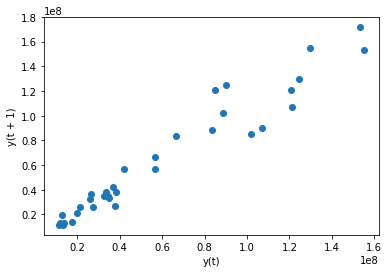

In [99]:
pd.plotting.lag_plot(temp)
plt.show()

In [100]:
values = pd.DataFrame(temp.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't']
result = dataframe.corr()
print(result)

          t-1         t
t-1  1.000000  0.968522
t    0.968522  1.000000


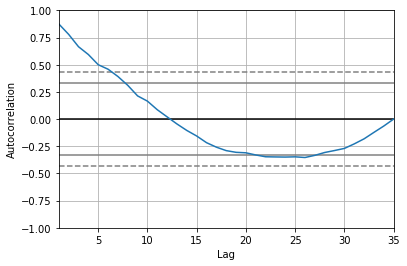

In [101]:
pd.plotting.autocorrelation_plot(temp)
plt.show()

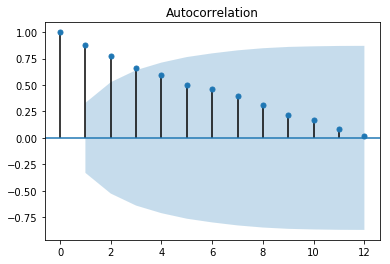

In [102]:
plot_acf(temp, lags=12)
plt.show()

The autocorrelation seems to be quite high<br>
We will use the same approach of creating a separate model for each property type and municipality and manually compute the root mean square error accross the different models

In [103]:
total_error = 0.0
# split dataset
for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
    series = real_estate.Total_Price[(real_estate.REFNIS == row['REFNIS']) &
                                     (real_estate.Property_Type == row['Property_Type'])]
    X = series.values
    train, test = X[1:len(X)-1], X[len(X)-1:]
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    total_error += (test[0] - predictions[0]) ** 2
print('Test RMSE: %.3f' % sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

Test RMSE: 12366690.314


The performance is the worst of all the models

### Filtered Data

Since there are a lot of municipalities with no transactions for some property type during some of the years, this might adversely impact performance, as the scatterplot goes up and down somewhat randomly<br>
Let us remove these municipality/property type combinations from the data and check the performance afterwards. We will only do this for the linear and the autoregression models

In [104]:
#Drop the municipality/property type combinations for which there is at least one record with less than 10 transactions
temp = real_estate.loc[real_estate.Total_Transactions < 10, ['Property_Type', 'REFNIS']].drop_duplicates()
real_estate = real_estate.merge(temp, how = 'left', indicator = True)
real_estate = real_estate[real_estate['_merge'] == 'left_only']
real_estate.drop('_merge', axis = 1, inplace = True)

In [105]:
# Keep at least 10 years
for start_year in range(1980, 2005):
    total_error = 0.0
    X = np.array(range(start_year, 2014)).reshape(-1, 1)
    year_to_predict = np.array(2014).reshape(-1, 1)
    for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
        temp = real_estate[(real_estate.Year >= start_year) &
                           (real_estate.Property_Type == row['Property_Type']) &
                           (real_estate.REFNIS == row['REFNIS'])]
        linreg = linear_model.LinearRegression()
        y = temp.Total_Price[temp.Year < 2014]
        linreg.fit(X, y)
        preds = linreg.predict(year_to_predict)
        total_error += (preds[0] - temp.Total_Price[temp.Year == 2014].values[0]) ** 2
    print(sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

14739806.939540448
14242785.680203957
13797952.09900183
13373794.8557538
12990095.807441952
12611112.505535932
12230171.630374404
11844253.202755323
11481648.109813686
11120669.474024076
10743851.580761855
10369830.003373565
9982219.24266359
9593782.78637951
9262178.602657398
8934376.958682908
8679870.501318099
8431185.898931397
8216294.8753809165
8032901.663720967
7813799.069859538
7627607.460101926
7454047.10072855
7061678.639783175
6845966.645330118


The error is higher, however, the average now is

In [106]:
np.mean(real_estate.Total_Price[real_estate.Year == 2014])

24561951.18022042

so the relative error went down<br>
How about the model based on previous year's total income ?

In [107]:
# Keep at least 10 years
for start_year in range(1981, 2005):
    total_error = 0.0
    for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
        temp = real_estate[(real_estate.Year >= start_year) &
                           (real_estate.Property_Type == row['Property_Type']) &
                           (real_estate.REFNIS == row['REFNIS'])]
        linreg = linear_model.LinearRegression()
        X = temp.Total_Income[temp.Year < 2014].values.reshape(-1, 1)
        y = temp.Total_Price[temp.Year < 2014]
        linreg.fit(X, y)
        preds = linreg.predict(temp.Total_Income[temp.Year == 2014].values.reshape(-1, 1))
        total_error += (preds[0] - temp.Total_Price[temp.Year == 2014].values[0]) ** 2
    print(sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

10460705.605694834
10299791.027509466
10145449.428510092
10017849.244435597
9889938.69215486
9749313.307627857
9611817.417621177
9502971.711975785
9401245.448547835
9324242.67709834
9219557.530887315
9079066.358788129
8934843.826946447
8810952.479484946
8672485.851630764
8529551.655445645
8368782.730196029
8211068.794160518
8054857.14201307
7856202.928652195
7660007.9904777575
7513609.752127302
7214552.546908635
7191069.507739999


We notice the same behaviour of performance starting off better than that of the model using the year as predictor, while being surpassed when only recent years are used<br>
Let us see how the autoregression model does on the new data

In [108]:
total_error = 0.0
# split dataset
for index, row in real_estate[['Property_Type', 'REFNIS']].drop_duplicates().iterrows():
    series = real_estate.Total_Price[(real_estate.REFNIS == row['REFNIS']) &
                                     (real_estate.Property_Type == row['Property_Type'])]
    X = series.values
    train, test = X[1:len(X)-1], X[len(X)-1:]
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    total_error += (test[0] - predictions[0]) ** 2
print('Test RMSE: %.3f' % sqrt(total_error / real_estate[['Property_Type', 'REFNIS']].drop_duplicates().shape[0]))

Test RMSE: 12760835.991


The performance is still worse than that of the best linear models

## Conclusions

It seems that the best performance we can get is by using a linear regressor for about 10 years' worth of data. XGBoost and the autoregressive model do worse, which is probably due to the linear nature of the data. A simple linear model is enough to capture the tendency, while there is probably not enough data (for a municipality/property type combination) for autoregression and XGBoost is too complex for this case. Removing the municipalities with very few transactions increases the absolute error but improves the relative one